# Data exploration workflow with diffprivlib

In [1]:
%matplotlib inline

import numpy as np
import diffprivlib as dp
import matplotlib.pyplot as plt

## Data and differential privacy set-up

We begin by initialising a `BudgetAccountant` to track the privacy spend of our exploration. By using the `set_default()` method, this accountant will be used by default in all diffprivlib calls.

In [2]:
acc = dp.BudgetAccountant(1, 0)
acc.set_default()

# Our default epsilon value for this exploration
eps = 0.04

We will use the Covertype dataset for this example. We can load is using `sklearn`. For the purpose of this exploration, we will use a numerical encoding of the "Wilderness Area" and "Soil Type" attributes. This will simplify visualisations later on.

In [3]:
from sklearn.datasets import fetch_covtype

dataset = fetch_covtype()
data, labels = dataset.data, dataset.target

# Switch from one-hot encoding to numerical encoding for Wilderness Area and Soil Type
data = np.concatenate((
    data[:, :-44], 
    (data[:, -44:-40] * np.arange(0, 4)).sum(axis=1)[:, np.newaxis],
    (data[:, -40:] * np.arange(0, 40)).sum(axis=1)[:, np.newaxis]
), axis=1)

n_examples = data.shape[0]

To assist our exploration, we will also specify the column names, and the ranges of each column. In this case, the ranges are assumed to be public knowledge, and therefore are not required to be calculated on the data. If the range is not known, it is common to search using a differentially private histogram.

In [4]:
col_names = ["Elevation", "Aspect", "Slope", "H-Distance To Hydrology", 
             "V-Distance To Hydrology", "H-Distance To Roadways", 
             "Hillshade 9am", "Hillshade Noon", "Hillshade 3pm", 
             "H-Distance To Fire Points", "Wilderness Area", "Soil Type"]

ranges = [(1000.0, 4000.0), (0, 360), (0, 66), (0, 1000.0), (0, 1000.0),
  (10, 10000.0), (0, 255), (0, 255), (0, 255), (10, 10000.0), (0, 3), (0, 39)]

assert len(col_names) == len(ranges)

## Initial exploration

The `histogram` function is a useful tool to visualise the data in a differentially private way. The syntax is the same as the corresponding function in NumPy, with the addition of an `epsilon` parameter. Also, to preserve differential privacy, we must specify the `range` of the histogram.

In this first example, we plot the number of examples of each of the Covertype labels, 1‒7. The counts are not exact due to differential privacy, but give a good approximation of the true values. We can see that almost 50% of examples in the dataset are associated with the label "2".

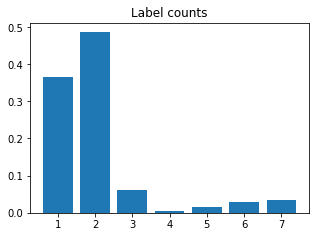

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5,3.5))

ax.bar(np.linspace(1, 7, 7), dp.tools.histogram(labels, epsilon=eps, bins=7, range=(1, 8))[0] / n_examples)
ax.set_title("Label counts")
plt.show()

We can also plot the distribution of features in the dataset using `histogram`. 

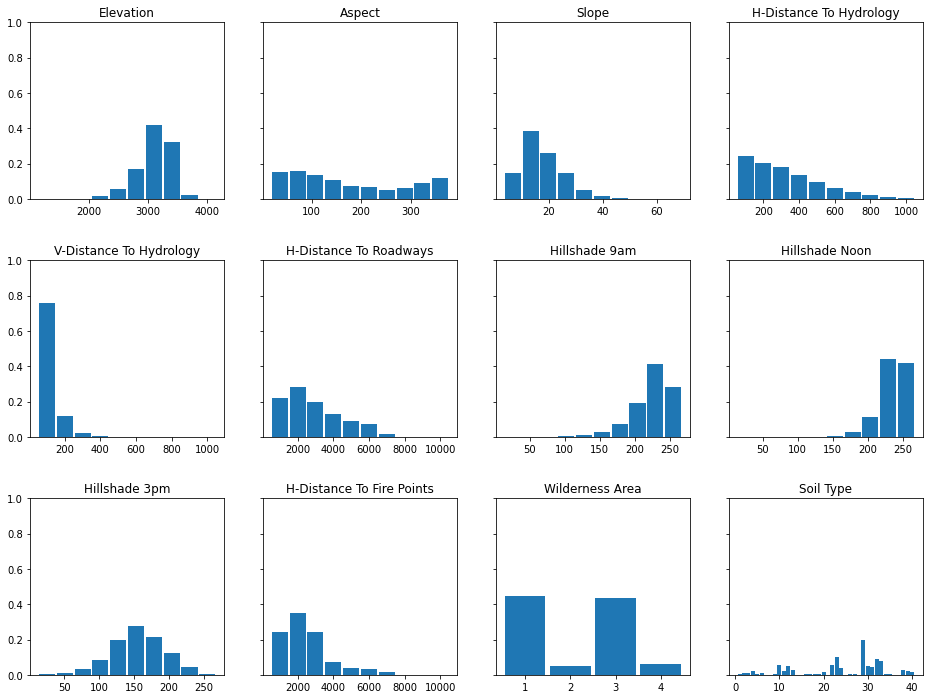

In [6]:
fig, axs = plt.subplots(3, 4, sharey=True, figsize=(16, 12))
fig.subplots_adjust(hspace=0.35)

for i in range(len(col_names)):
    ax = axs.flat[i]
    ax.set_title(col_names[i])
    _range = ranges[i]
    n_bins = 10
    
    # Wilderness Area and Soil Type need special config
    if i >= 10:
        _range = (0, _range[1] + 1)
        n_bins = _range[1]

    bar_width = (_range[1] - _range[0]) / n_bins * 0.9
    
    hist, bins = dp.tools.histogram(data[:, i], bins=n_bins, range=_range, epsilon=eps)
    ax.bar(bins[:-1] + np.diff(bins), hist / n_examples, width=bar_width)
    ax.set_ylim(0, 1)

plt.show()

After our initial exploration, now is a good time to examine our budget spend, confirming that we have executed 13 queries thus far.

In [7]:
acc.total()

(epsilon=0.5199999999999999, delta=0.0)

In [8]:
len(acc)

13

## Additional exploration

We can also use 2-dimensional histograms to extract more information in a differentially private way. In this example, we can plot the distribution of a feature with respect to each label.

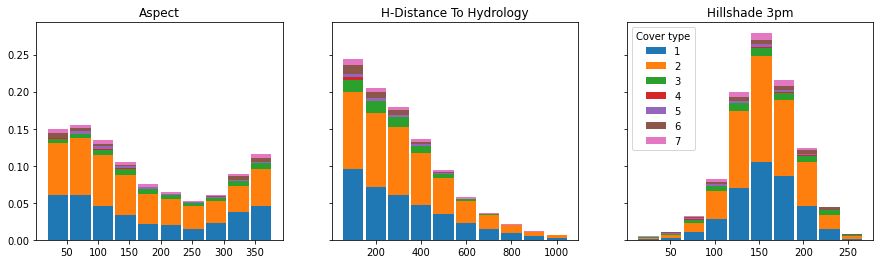

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
n_bins = 10

# Columns of the dataset we want to plot
cols = (1, 3, 8)

for _i, col in enumerate(cols):
    ax = axs.flat[_i]
    ax.set_title(col_names[col])
    width = (ranges[col][1] - ranges[col][0]) / n_bins * 0.9

    hist, bins, _ = dp.tools.histogram2d(data[:, col], labels, epsilon=eps, bins=(n_bins, 7), 
                                             range=(ranges[col], (1, 8)))
    cum_sum = np.zeros_like(hist[:, 0])

    for i in range(hist.shape[1]):
        ax.bar(bins[:-1] + np.diff(bins), hist[:, i] / n_examples, bottom=cum_sum, label=str(i+1), width=width)
        cum_sum += hist[:, i] / n_examples
        
ax.legend(title="Cover type")
plt.show()

With some extra effort, we can also produce 2-dimensional histograms to show correlation between features.

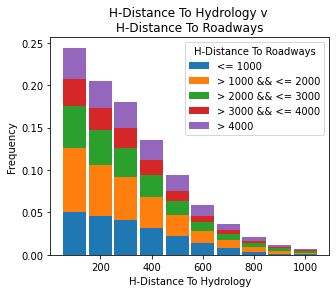

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
col1, col2 = (3, 5)

n_bins = 10

ax.set_title(col_names[col1] + " v \n" + col_names[col2])
width = (ranges[col1][1] - ranges[col1][0]) / n_bins * 0.9

hist, bins, _ = dp.tools.histogram2d(
    data[:, col1], 
    (data[:, col2] > 1000).astype(int) + (data[:, col2] > 2000) + (data[:, col2] > 3000) + (data[:, col2] > 4000), 
    epsilon=eps, bins=(n_bins, 5), range=(ranges[col1], (0, 5))
)
legends = ["<= 1000", "> 1000 && <= 2000", "> 2000 && <= 3000", "> 3000 && <= 4000", "> 4000"]

cum_sum = np.zeros_like(hist[:, 0])

for i in range(hist.shape[1]):
    ax.bar(bins[:-1] + np.diff(bins), hist[:, i] / n_examples, bottom=cum_sum, label=legends[i], width=width)
    cum_sum += hist[:, i] / n_examples

ax.set_xlabel(col_names[col1])
ax.set_ylabel("Frequency")
ax.legend(title=col_names[col2])
plt.show()

## Colour maps

We can also use the 2-dimensional histogram to plot colour maps of the data. This allows us to examine correlations between features.

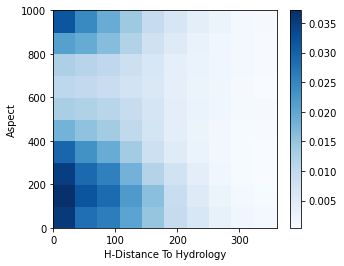

In [11]:
col1, col2 = (1, 3)

hist, bins_y, bins_x = dp.tools.histogram2d(data[:, col1], data[:, col2], epsilon=eps, 
                                            range=(ranges[col1], ranges[col2]))

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
c = ax.pcolormesh(bins_y, bins_x, hist / n_examples, cmap='Blues')
ax.set_ylabel(col_names[col1])
ax.set_xlabel(col_names[col2])
fig.colorbar(c, ax=ax)
plt.show()

## Other queries

Diffprivlib includes a number of simple statistical functions to examine the data in more detail. These include `mean`, `var`, `sum` and `count_nonzero` functions.  They can be useful in querying more specific information than can be portrayed by histograms.

In [12]:
dp.tools.mean(data[:, 0], bounds=ranges[0], epsilon=eps)

2959.413492430157

In [13]:
dp.tools.var(data[:, 0], bounds=ranges[0], epsilon=eps)

76507.10941871432

`count_nonzero` is useful for counting more specific information than is required from a histogram.

In [14]:
dp.tools.count_nonzero(data[:, 0] >= 3000, epsilon=eps) / n_examples

0.49394160533689496

We can also get label-specific information by indexing the `data` array appropriately.

In [15]:
dp.tools.mean(data[labels==1, 0], bounds=ranges[0], epsilon=eps)

3128.5443965699988

## Total privacy loss

Having completed our initial exploration, we can compute the total privacy loss from the accountant.

In [16]:
acc.total()

(epsilon=0.8800000000000002, delta=0.0)

And we can also compute the remaining budget to be spent on subsequent queries.

In [17]:
acc.remaining()

(epsilon=0.11999999999999988, delta=0.0)